# ETL - Read the CSV files and load data into dataframe

In [46]:
# Import dependencies
import pandas as pd
import sqlite3
import numpy as np
from tabulate import tabulate 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from wordcloud import STOPWORDS
import re
import altair as alt

In [47]:
# Define the path to the CSV file
survey_1_raw_data = 'data/survey_1.csv'
survey_2_raw_data = 'data/survey_2.csv'
survey_3_raw_data = 'data/classified_usa_comments.csv'

In [48]:
# Load the CSV data into a DataFrame
survey_1_df = pd.read_csv('data/survey_1.csv')
survey_2_df = pd.read_csv('data/survey_2.csv')
survey_3_df = pd.read_csv('data/classified_usa_comments.csv')

# ETL - Create SQLite database, create tables, create combined table of datasets

In [49]:
# Create a connection to the SQLite database
conn = sqlite3.connect('survey_database.db')
cursor = conn.cursor()

In [50]:
# Create the first table in SQLite
survey_1_df.to_sql('survey_1', conn, if_exists='replace', index=False)

# Create the second table in SQLite
survey_2_df.to_sql('survey_2', conn, if_exists='replace', index=False)

# Create the third table in SQLite
survey_3_df.to_sql('survey_3', conn, if_exists='replace', index=False)

103

In [51]:
# Drop the combined table if it already exists
cursor.execute("DROP TABLE IF EXISTS survey_data_combined;")

# Create the combined table in SQLite
cursor.execute("""
CREATE TABLE survey_data_combined AS
SELECT s1.*, s2.*, s3.classification
FROM survey_1 s1
JOIN survey_2 s2 ON s1.survey_id = s2.survey_id
LEFT JOIN survey_3 s3 ON s1.survey_id = s3.survey_id;
""")

# Commit the changes and close the connection
conn.commit()


In [52]:
# Verify that the data was combined successfully by querying the survey_data table
result = pd.read_sql_query("SELECT * FROM survey_data_combined", conn)

In [53]:
# Close the connection
conn.close()

In [54]:
# Display the combined data
print(tabulate(result, headers='keys', tablefmt='psql'))

+------+------------------+-------------+------------------------------------------------+------------------------+---------+-----------------+------------------+-------------+------------------+----------------+----------------+-------------+---------------+---------------+----------------+------------+----------------+--------------------+-------------+-------------+--------------------+-----------------------------+---------------------------+--------------+--------------+---------------------------+-------------------------+----------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Cleanup the Columns

### Clean up column[Gender] in United States

In [55]:
survey_data_comb = result.copy()
survey_data_comb['Gender'] = survey_data_comb['Gender'].str.strip()
survey_data_comb['Gender'] = survey_data_comb['Gender'].str.lower()

male_variations = ['male', 'm', 'maile', 'cis male', 'mal', 'male (cis)', 'make', 'man', 'msle', 'mail', 'malr', 'cis man', 'Cis Male', 'M', 'Male', 'Male (CIS)']
female_variations = ['female', 'f', 'cis female', 'woman', 'femake', 'female (cis)', 'femail', 'Cis Female', 'F', 'Female', 'Femake', 'cis-female', 'femme', 'Female (cis)', 'cis-female/femme']

for male_variation in male_variations:
    survey_data_comb['Gender'] = survey_data_comb['Gender'].replace(male_variation, 'M')

for female_variation in female_variations:
    survey_data_comb['Gender'] = survey_data_comb['Gender'].replace(female_variation, 'F')


### Determine Remaining Values in Gender Column

In [56]:
remaining = survey_data_comb[survey_data_comb['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head()

22


Timestamp  Age                 Gender        Country state  \
55   8/27/2014 11:46   27               male-ish  United States    NY   
72   8/27/2014 11:54   23           trans-female  United States    MA   
93   8/27/2014 12:15   18  something kinda male?         Russia  None   
306  8/27/2014 14:22   30         queer/she/they  United States    IL   
349  8/27/2014 14:47   25             non-binary  United States    CA   

    self_employed family_history treatment work_interfere    no_employees  \
55             No            Yes       Yes         Rarely          26-100   
72             No             No        No         Rarely  More than 1000   
93             No             No        No           None          26-100   
306            No            Yes       Yes         Rarely          26-100   
349            No            Yes       Yes      Sometimes  More than 1000   

     ... mental_health_consequence  phys_health_consequence     coworkers  \
55   ...                     Maybe                       No            No   
72   ...                     Maybe                       No           Yes   
93   ...                        No                       No           Yes   
306  ...                     Maybe                       No  Some of them   
349  ...                     Maybe                       No  Some of them   

       supervisor mental_health_interview phys_health_interview  \
55             No                      No                    No   
72            Yes                      No                    No   
93            Yes                     Yes                   Yes   
306           Yes                      No                    No   
349  Some of them                      No                    No   

    mental_vs_physical obs_consequence  \
55          Don't know              No   
72                  No              No   
93          Don't know              No   
306         Don't know              No   
349                Yes              No   

                                              comments Classification  
55                                                None           None  
72                                                None           None  
93   In Russia we have mandatory medical insurance....           None  
306                                               None           None  
349                                               None           None  

[5 rows x 31 columns]

### Abbreviate Genders

In [57]:
gender_abbreviations = {
    "trans-female"  : "TF",
    "trans woman"   : "TF",
    "female (trans)": "TF",
    "trans-male"    : "TM",
    "genderqueer"   : "Q",
    "queer/she/they": "Q",
    "non-binary"    : "NB",
    "male-ish"      : "NB",
    "nah"           : "NB"
}

for gender_name, gender_abbreviation in gender_abbreviations.items():
    survey_data_comb['Gender'] = survey_data_comb['Gender'].replace(gender_name, gender_abbreviation)

survey_data_comb.head()


Timestamp  Age Gender         Country state self_employed  \
0  8/27/2014 11:29   37      F   United States    IL          None   
1  8/27/2014 11:29   44      M   United States    IN          None   
2  8/27/2014 11:29   32      M          Canada  None          None   
3  8/27/2014 11:29   31      M  United Kingdom  None          None   
4  8/27/2014 11:30   31      M   United States    TX          None   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often          25-Jun  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely          25-Jun  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

  mental_health_consequence  phys_health_consequence     coworkers supervisor  \
0                        No                       No  Some of them        Yes   
1                     Maybe                       No            No         No   
2                        No                       No           Yes        Yes   
3                       Yes                      Yes  Some of them         No   
4                        No                       No  Some of them        Yes   

  mental_health_interview phys_health_interview mental_vs_physical  \
0                      No                 Maybe                Yes   
1                      No                    No         Don't know   
2                     Yes                   Yes                 No   
3                   Maybe                 Maybe                 No   
4                     Yes                   Yes         Don't know   

  obs_consequence comments Classification  
0              No     None           None  
1              No     None           None  
2              No     None           None  
3             Yes     None           None  
4              No     None           None  

[5 rows x 31 columns]

### Verify data in Gender columns who live in United States are correctly abbreviated

In [58]:
remaining = survey_data_comb[survey_data_comb['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head(23)

22


Timestamp          Age  \
55    8/27/2014 11:46           27   
72    8/27/2014 11:54           23   
93    8/27/2014 12:15           18   
306   8/27/2014 14:22           30   
349   8/27/2014 14:47           25   
387   8/27/2014 15:24           29   
390   8/27/2014 15:24  99999999999   
413   8/27/2014 15:30           31   
416   8/27/2014 15:31           30   
451   8/27/2014 15:53           40   
544   8/27/2014 18:13           28   
553   8/27/2014 18:56           21   
626    8/28/2014 2:15           37   
628    8/28/2014 2:19           32   
682    8/28/2014 9:02           19   
777   8/28/2014 12:10           32   
805   8/28/2014 13:47           28   
818   8/28/2014 14:46           26   
989    8/29/2014 9:10            8   
1017   8/29/2014 9:58           46   
1127  8/30/2014 20:55           -1   
1234   2/24/2015 9:15           24   

                                              Gender         Country state  \
55                                                NB   United States    NY   
72                                                TF   United States    MA   
93                             something kinda male?          Russia  None   
306                                                Q   United States    IL   
349                                               NB   United States    CA   
387                                               NB   United States    CA   
390                                              all        Zimbabwe  None   
413                                             enby  United Kingdom  None   
416                                            fluid         Germany  None   
451                                                Q   United States    VA   
544                                        androgyne  United Kingdom  None   
553                                          agender  United Kingdom  None   
626                                   guy (-ish) ^_^          Canada  None   
628                         male leaning androgynous          Canada  None   
682                                               TF   United States    MO   
777                                           neuter  United Kingdom  None   
805                                               TF   United States    CA   
818                                            queer         Germany  None   
989                               a little about you    Bahamas, The    IL   
1017                                              TF   United States    CT   
1127                                               p   United States    AL   
1234  ostensibly male, unsure what that really means  United Kingdom  None   

     self_employed family_history treatment work_interfere    no_employees  \
55              No            Yes       Yes         Rarely          26-100   
72              No             No        No         Rarely  More than 1000   
93              No             No        No           None          26-100   
306             No            Yes       Yes         Rarely          26-100   
349             No            Yes       Yes      Sometimes  More than 1000   
387            Yes            Yes       Yes      Sometimes           5-Jan   
390            Yes            Yes       Yes          Often           5-Jan   
413             No            Yes       Yes      Sometimes  More than 1000   
416             No            Yes       Yes      Sometimes         100-500   
451             No            Yes        No          Never  More than 1000   
544             No            Yes       Yes         Rarely         100-500   
553             No             No       Yes      Sometimes          26-100   
626             No            Yes       Yes      Sometimes         100-500   
628             No             No        No      Sometimes          26-100   
682             No            Yes       Yes          Often          26-100   
777             No             No       Yes      Sometimes  More than 1000   
805             

### Filter Column['Age']

In [59]:
min_age = 0
max_age = 120
survey_data_comb = survey_data_comb[(survey_data_comb['Age'] >= min_age) & (survey_data_comb['Age'] <= max_age)]

### Clean Up Timestamp
1. Rename Timestamp to survey_date
2. Remove time - just keep date

In [60]:
survey_data_comb = survey_data_comb.rename(columns={'Timestamp': 'survey_date'})
survey_data_comb['survey_date'] = pd.to_datetime(survey_data_comb['survey_date']).dt.date
survey_data_comb.head()

survey_date  Age Gender         Country state self_employed family_history  \
0  2014-08-27   37      F   United States    IL          None             No   
1  2014-08-27   44      M   United States    IN          None             No   
2  2014-08-27   32      M          Canada  None          None             No   
3  2014-08-27   31      M  United Kingdom  None          None            Yes   
4  2014-08-27   31      M   United States    TX          None             No   

  treatment work_interfere    no_employees  ... mental_health_consequence  \
0       Yes          Often          25-Jun  ...                        No   
1        No         Rarely  More than 1000  ...                     Maybe   
2        No         Rarely          25-Jun  ...                        No   
3       Yes          Often          26-100  ...                       Yes   
4        No          Never         100-500  ...                        No   

   phys_health_consequence     coworkers supervisor mental_health_interview  \
0                       No  Some of them        Yes                      No   
1                       No            No         No                      No   
2                       No           Yes        Yes                     Yes   
3                      Yes  Some of them         No                   Maybe   
4                       No  Some of them        Yes                     Yes   

  phys_health_interview mental_vs_physical obs_consequence comments  \
0                 Maybe                Yes              No     None   
1                    No         Don't know              No     None   
2                   Yes                 No              No     None   
3                 Maybe                 No             Yes     None   
4                   Yes         Don't know              No     None   

  Classification  
0           None  
1           None  
2           None  
3           None  
4           None  

[5 rows x 31 columns]

## Can the Research Question be Answered 

In [61]:
survey_data_tech_workers = survey_data_comb[survey_data_comb['tech_company'] == 'Yes']
num_of_tech_workers = len(survey_data_tech_workers)

num_tw_with_mh_issues = survey_data_tech_workers[survey_data_tech_workers['mental_health_consequence'] == 'Yes']
num_tw_with_mh_issues = len(num_tw_with_mh_issues)

percentage_with_issues = float(num_tw_with_mh_issues) / float(num_of_tech_workers) * 100
percentage_with_issues = round(percentage_with_issues, 2)
percentage_with_issues

21.69

# Extract Data from Database, Run Analysis, Build Visualizations

In [62]:
# Connect to the database 
conn = sqlite3.connect('survey_database.db')

In [63]:
# Load data into a DataFrame
query = "SELECT * FROM survey_data_combined;"
df = pd.read_sql_query(query, conn)

In [64]:
survey_data_df = survey_data_comb.copy()
survey_data_df.head()

survey_date  Age Gender         Country state self_employed family_history  \
0  2014-08-27   37      F   United States    IL          None             No   
1  2014-08-27   44      M   United States    IN          None             No   
2  2014-08-27   32      M          Canada  None          None             No   
3  2014-08-27   31      M  United Kingdom  None          None            Yes   
4  2014-08-27   31      M   United States    TX          None             No   

  treatment work_interfere    no_employees  ... mental_health_consequence  \
0       Yes          Often          25-Jun  ...                        No   
1        No         Rarely  More than 1000  ...                     Maybe   
2        No         Rarely          25-Jun  ...                        No   
3       Yes          Often          26-100  ...                       Yes   
4        No          Never         100-500  ...                        No   

   phys_health_consequence     coworkers supervisor mental_health_interview  \
0                       No  Some of them        Yes                      No   
1                       No            No         No                      No   
2                       No           Yes        Yes                     Yes   
3                      Yes  Some of them         No                   Maybe   
4                       No  Some of them        Yes                     Yes   

  phys_health_interview mental_vs_physical obs_consequence comments  \
0                 Maybe                Yes              No     None   
1                    No         Don't know              No     None   
2                   Yes                 No              No     None   
3                 Maybe                 No             Yes     None   
4                   Yes         Don't know              No     None   

  Classification  
0           None  
1           None  
2           None  
3           None  
4           None  

[5 rows x 31 columns]

In [65]:
# Connect to the database 
conn = sqlite3.connect('survey_database.db')

In [66]:
# Load data into a DataFrame
query = "SELECT * FROM survey_data_combined;"
df = pd.read_sql_query(query, conn)

## Sam's Journey in the Tec Industry
A software engineer named Sam, worked at a FAANG and loved her job, but recently, she struggled. The long hours, tight deadlines, and constant pressure to innovate took a toll on her well-being. Despite her initial enthusiasm, she felt drained, anxious, and increasingly isolated. Over time, the stress began to manifest physically—Sam developed high blood pressure, became dependent on caffeine to keep up with the relentless demands, and even suffered from stomach ulcers. She also felt a lack of support from her team and management, which only worsened her situation.
Sam's story wasn’t unique. In fact, it was more common than many realized. Today, we’ll explore why mental health challenges were so prevalent in the tech industry and what the data revealed about the factors that contributed to these issues.

### Problem
While physical health is easily measurable and often prioritized in the workplace, mental health is frequently overlooked or misunderstood.

### The Data
 We will analyze data from a survey focused on mental health and workplace dynamics, filtered to include only respondents from the United States. This data includes information on company size, remote work, mental vs physical health, open-ended comments, and classifications from employees.

In [67]:
print(survey_data_df.columns)

Index(['survey_date', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'company size', 'survey_id', 'survey_id:1', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments', 'Classification'],
      dtype='object')


In [68]:
# Filter data to only include respondents from the United States and select relevant columns
usa_data = survey_data_df[survey_data_df['Country'] == 'United States'][[
   'Age', 'benefits', 'leave', 'seek_help', 'mental_health_consequence', 'phys_health_consequence', 
    'company size', 'remote_work', 'work_interfere', 'mental_vs_physical', 'comments', 'Classification'
]]

usa_data

Age    benefits               leave   seek_help  \
0      37         Yes       Somewhat easy         Yes   
1      44  Don't know          Don't know  Don't know   
4      31         Yes          Don't know  Don't know   
5      33         Yes          Don't know  Don't know   
6      35          No  Somewhat difficult          No   
...   ...         ...                 ...         ...   
1253   36  Don't know       Somewhat easy         Yes   
1255   32         Yes  Somewhat difficult          No   
1256   34         Yes  Somewhat difficult          No   
1257   46          No          Don't know          No   
1258   25         Yes          Don't know          No   

     mental_health_consequence phys_health_consequence company size  \
0                           No                      No        Small   
1                        Maybe                      No        Large   
4                           No                      No       Medium   
5                           No                      No        Small   
6                        Maybe                   Maybe        Small   
...                        ...                     ...          ...   
1253                     Maybe                   Maybe        Large   
1255                        No                      No       Medium   
1256                       Yes                     Yes        Large   
1257                       Yes                      No       Medium   
1258                     Maybe                      No       Medium   

     remote_work work_interfere mental_vs_physical comments Classification  
0             No          Often                Yes     None           None  
1             No         Rarely         Don't know     None           None  
4            Yes          Never         Don't know     None           None  
5             No      Sometimes         Don't know     None           None  
6            Yes      Sometimes         Don't know     None           None  
...          ...            ...                ...      ...            ...  
1253          No         Rarely         Don't know     None           None  
1255         Yes          Often                Yes     None           None  
1256          No      Sometimes                 No     None           None  
1257         Yes           None                 No     None           None  
1258          No      Sometimes         Don't know     None           None  

[748 rows x 12 columns]

### Classification and Comments DataFrame

In [69]:
# Drop rows where comments are NA
usa_data_df = usa_data.dropna(subset=['comments'])

# Create a new dataframe with selected columns and rename them
usa_data_df = usa_data_df[['Classification', 'comments']].copy()
usa_data_df.columns = ['Classification', 'Comments']

# Display the new dataframe
usa_data_df

Classification                                           Comments
13     Unclassified  I'm not on my company's health insurance which...
15             Both  I have chronic low-level neurological issues t...
24     Unclassified                Relatively new job. Ask again later
25             Both  Sometimes I think  about using drugs for my me...
33             Both  I selected my current employer based on its po...
...             ...                                                ...
1186   Unclassified  I'm self-employed on contract with small start...
1190           Both  My mental health issues were the direct result...
1219           Both  I openly discuss my mental health struggles. I...
1221   Unclassified  Just starting a new job hence the numerous I d...
1249           Both                                  Bipolar disorder 

[103 rows x 2 columns]

### A Revealing Disparity
One of the most telling indicators of an organization's culture is how it treats mental health compared to physical health. In Sam's case, her mental health challenges were often overlooked, while her physical ailments were treated with more urgency.

The team decided to create a bar chart to represent a broader view of how employees across the tech industry perceive the balance—or imbalance—between these two aspects of health, primarily due to inadequate communication and a perceived lack of emphasis on mental health issues.

The results highlight a significant disparity, with many employees feeling that their mental health is not given the same level of attention as their physical health. This gap can exacerbate issues like those Sam faced, where mental health struggles remain unaddressed until they manifest as physical symptoms, by which time the damage may already be done.

/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/3205580727.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='mental_vs_physical', data=usa_data, palette='viridis')


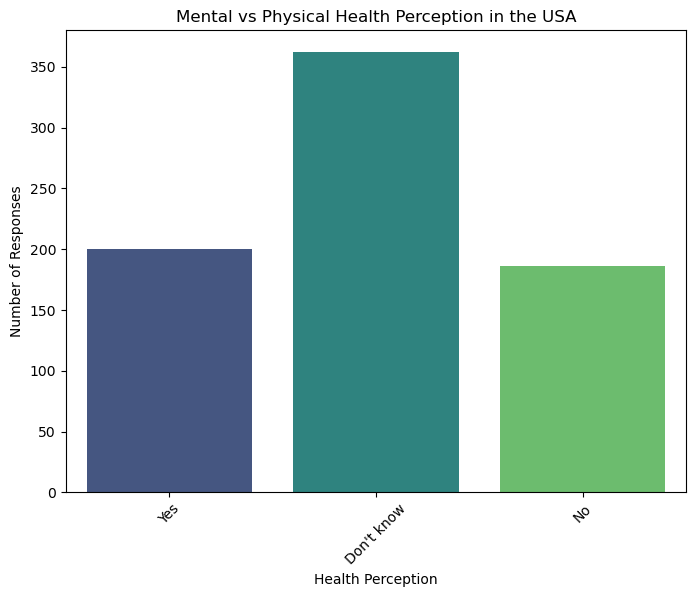

In [70]:
# Generate a visual for mental vs physical health
# Survey Question: Do you feel that your employer takes mental health as seriously as physical health?

plt.figure(figsize=(8, 6))
sns.countplot(x='mental_vs_physical', data=usa_data, palette='viridis')
plt.title('Mental vs Physical Health Perception in the USA')
plt.xlabel('Health Perception')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45)
plt.show()

### Mental health consequences compared with Physical health consequences
This shows the clear scale of mental health issues in corporate world.

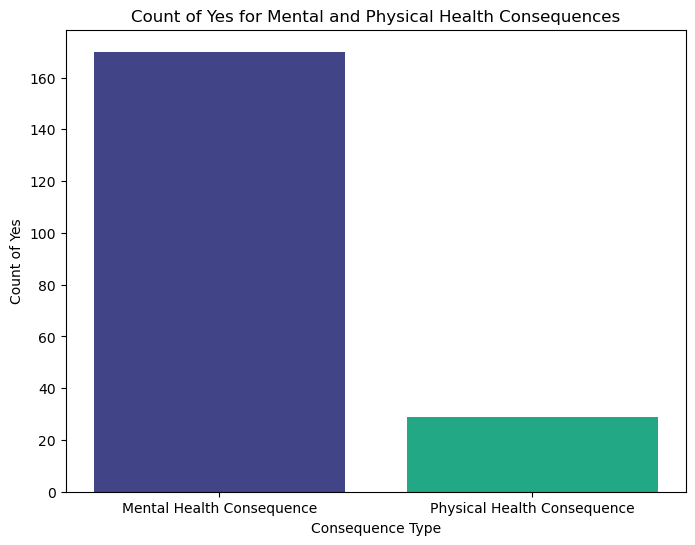

In [84]:
import matplotlib.pyplot as plt

# Count the occurrences of 'Yes' in each column
mental_health_yes = usa_data['mental_health_consequence'].value_counts().get('Yes', 0)
phys_health_yes = usa_data['phys_health_consequence'].value_counts().get('Yes', 0)

# Data for plotting
categories = ['Mental Health Consequence', 'Physical Health Consequence']
counts = [mental_health_yes, phys_health_yes]

# Create a bar plot
plt.figure(figsize=(8, 6))

# Apply viridis colormap
colors = plt.cm.viridis([0.2, 0.6])

plt.bar(categories, counts, color=colors)

# Adding labels and title
plt.xlabel('Consequence Type')
plt.ylabel('Count of Yes')
plt.title('Count of Yes for Mental and Physical Health Consequences')

# Display the plot
plt.show()


/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/323958217.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='company size', data=usa_data, ax=axs[0, 1], palette="viridis")
/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/323958217.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/323958217.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='work_interfere', data=usa_data, 

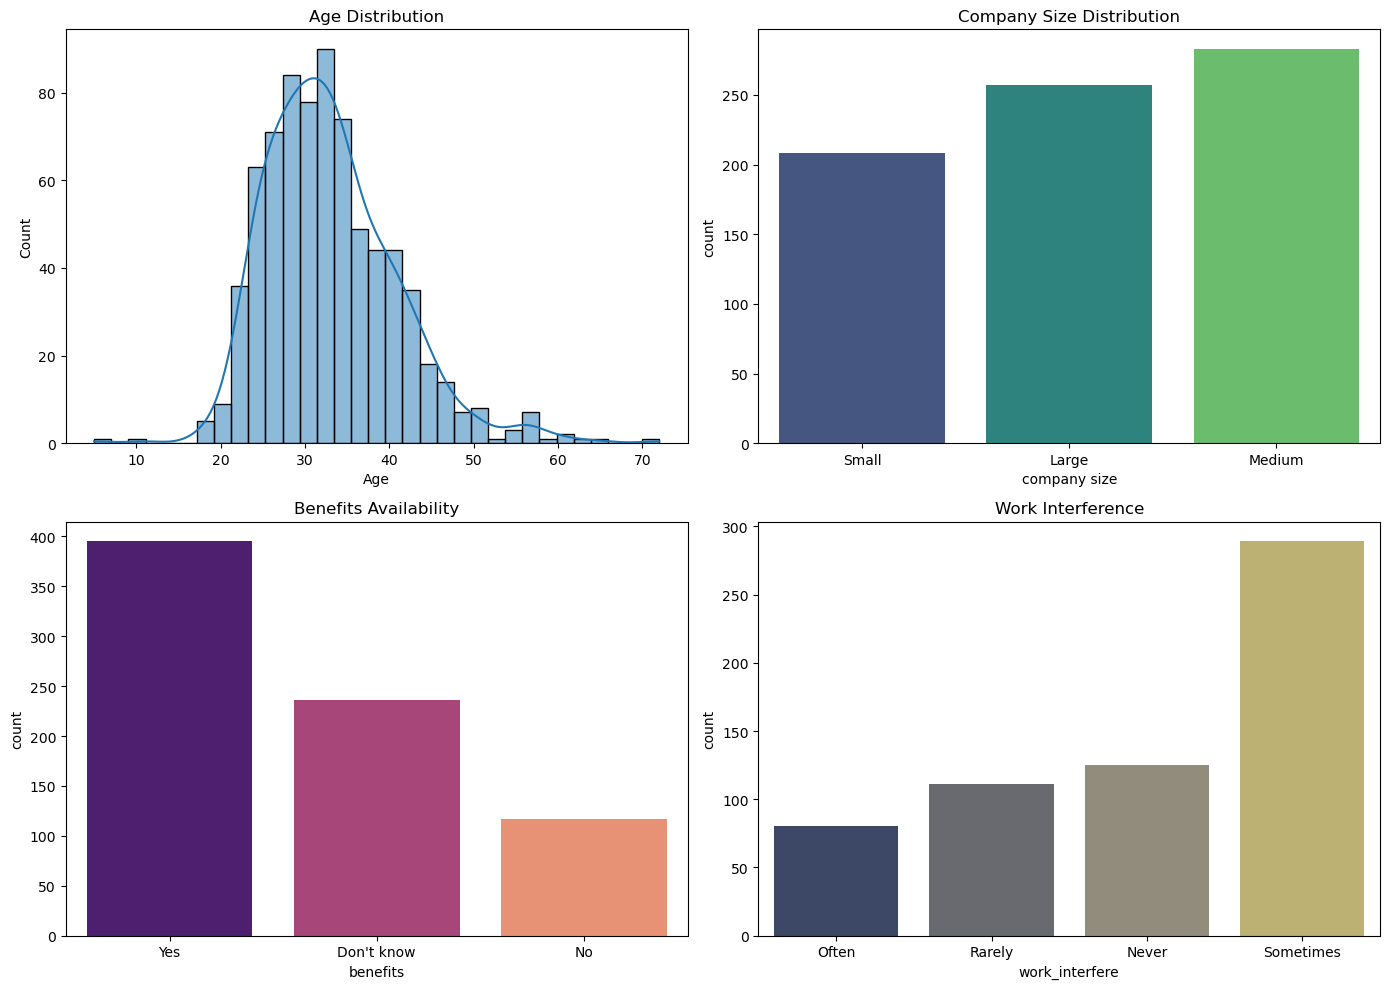

In [72]:
# General exploratory visualizations
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plotting distributions of Age
sns.histplot(usa_data['Age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')

# Plotting count of company size
sns.countplot(x='company size', data=usa_data, ax=axs[0, 1], palette="viridis")
axs[0, 1].set_title('Company Size Distribution')

# Plotting count of benefits availability
sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
axs[1, 0].set_title('Benefits Availability')

# Plotting count of work interference
sns.countplot(x='work_interfere', data=usa_data, ax=axs[1, 1], palette="cividis")
axs[1, 1].set_title('Work Interference')
plt.tight_layout()

# Show plot
plt.show()

### The Voices Behind the Data
Every number has a story behind it, just like Sam’s. By analyzing the comments left by survey respondents, we can hear directly from those who are experiencing similar struggles. By examining the number of comments, we were able to identify and quantify the most frequently mentioned health-related issues. Filtering and counting occurrences of specific keywords related to mental and physical health provided us with valuable insights into the common concerns among employees. This step helps us focus on the key themes that are most relevant to understanding the overall health challenges faced by the workforce.

In [73]:
# Drop rows with None or NaN values in the comments column
usa_comments_df = usa_data.dropna(subset=['comments'])

# Count the number of rows that contain comments from the filtered USA dataset. 
usa_comments = usa_comments_df.shape[0]

# Print the results
print(f"Number of rows with comments: {usa_comments}")

Number of rows with comments: 103


In [74]:
# Combine all comments into one text
comment_text = " ".join(comment for comment in usa_comments_df.comments if isinstance(comment, str))

# Split the comments into individual words
all_words = comment_text.split()

# Define a list of common health-related keywords
health_keywords = [
    "health", "mental", "physical", "stress", "anxiety", "depression", "wellbeing", 
    "therapy", "counseling", "burnout", "pressure", "fatigue", "support", "strain", 
    "illness", "disease", "recovery", "wellness", "treatment"
]

# Count the occurrences of these health-related words in the comments
word_counts = Counter(word.lower() for word in all_words if word.lower() in health_keywords)

# Convert the counter to a DataFrame for better readability
health_word_count_df = pd.DataFrame(word_counts.items(), columns=["Health Related Word", "Frequency"])

# Sort the DataFrame by frequency
health_word_count_df = health_word_count_df.sort_values(by="Frequency", ascending=False)

# Display the table
print(health_word_count_df)

   Health Related Word  Frequency
1               mental         71
0               health         70
3           depression          8
4              anxiety          8
7              illness          7
9            treatment          6
6              support          5
5              therapy          4
8             physical          4
2             wellness          3
11          counseling          2
10             burnout          1
12              stress          1


### The Language of Struggle: A Word Cloud of Employee Concerns
To deepen our understanding of the health-related concerns expressed by employees, we expanded our list of relevant keywords to include more specific and varied terms. This approach allowed us to capture a broader range of issues and experiences mentioned in the comments. By generating a word cloud using these expanded health-related terms, we visually highlighted the most commonly discussed themes. Interestingly, terms like "mental health," "burnout," and "depression" emerged as the primary concerns among employees.

Similar to Sam’s experience, the pressure of work paints a vivid picture of the challenges faced by tech workers who participated in this survey. What surprised the team was discovering that many workers in the U.S. lack support from their employers to improve their health. In some cases, these employees are even viewed as liabilities rather than individuals in need of assistance. This finding highlights a critical gap in how organizations address the well-being of their workforce.

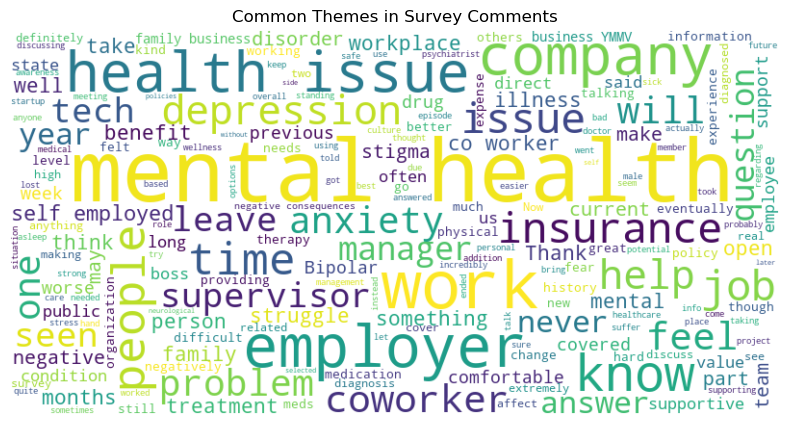

In [75]:
# Define stopwords
stopwords = set(STOPWORDS)

# Additional custom stopwords provided by the user
custom_stopwords = {"month", "option", "past", "say", "many", "want", "need", "etc", "back", "things", "seen" "new", "small", "understand", "fo", "always", 
                    "program", "even", "thing", "reason", "very", "might", "currently", "really", "lot", 
                    "non", "large", "day"}

# Combine the default stopwords with the custom stopwords
all_stopwords = stopwords.union(custom_stopwords)

# Generate the word cloud using the rows with comments and excluding both stopwords and custom stopwords
comment_text = " ".join(comment for comment in usa_comments_df.comments if isinstance(comment, str))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(comment_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Themes in Survey Comments")
plt.show()

### Uncovering the Hidden Layers of Mental Health Challenges
To delve deeper into the underlying mental health issues, we created a bar chart that identifies and counts the most relevant mental health-related terms mentioned by employees. After cleaning and filtering the comments, we focused on key terms such as "depression," "anxiety," and "stress," while grouping related terms like "therapy," "treatment," and "support" under "tts." By visualizing the data in this manner, we can prioritize the most critical issues and gain insights into the patterns of mental health challenges prevalent in the tech industry.

In [76]:
# Calculate the frequency of each classification
classification_frequency = usa_data_df['Classification'].value_counts()

# Convert the frequency count to a DataFrame
classification_frequency_df = classification_frequency.reset_index()
classification_frequency_df.columns = ['Classification', 'Frequency']

# Display the DataFrame
classification_frequency_df

Classification  Frequency
0           Both         46
1   Unclassified         42
2     Depression          9
3        Anxiety          6

/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/682716607.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


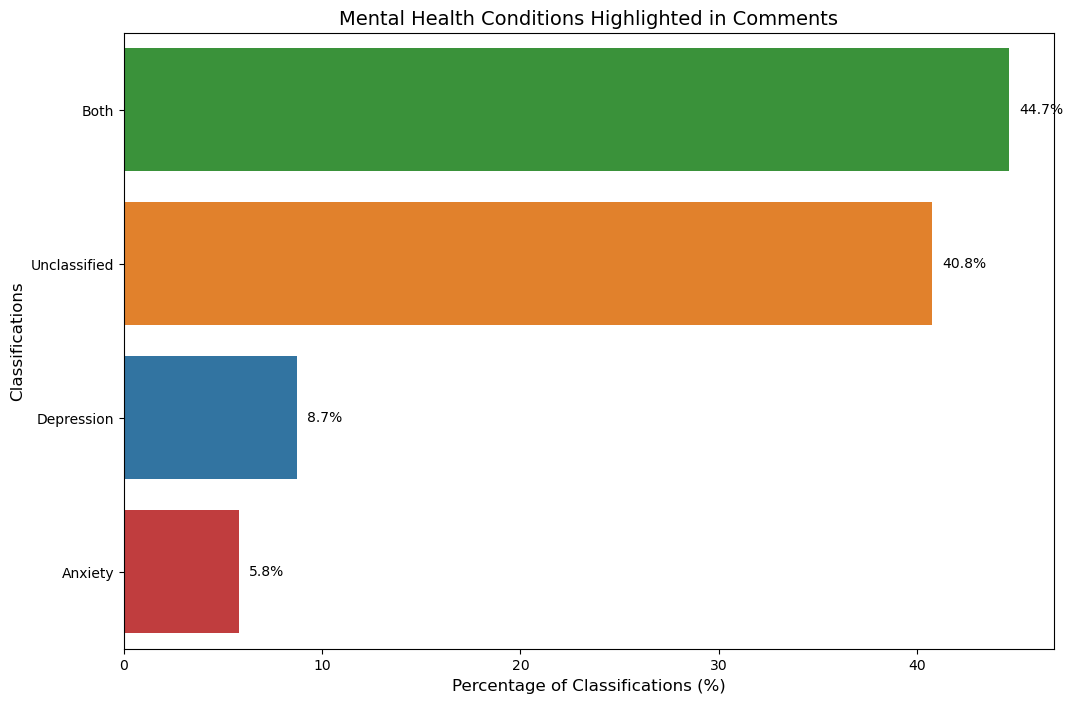

In [77]:
# Calculate the percentage of each classification
classification_frequency_df['Percentage'] = (classification_frequency_df['Frequency'] / classification_frequency_df['Frequency'].sum()) * 100

# Define the color palette for classifications
classification_colors = {
    'Both': '#2ca02c',          # Green
    'Unclassified': '#ff7f0e',  # Orange
    'Depression': '#1f77b4',    # Blue 
    'Anxiety': '#d62728'        # Red
}

# Create a custom palette based on the classification_colors dictionary
custom_palette = sns.color_palette([classification_colors.get(key, '#d62728') for key in classification_frequency_df['Classification']])

# Create the horizontal bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(
    x='Percentage',
    y='Classification',
    data=classification_frequency_df,
    palette=custom_palette,
    orient='h'  # Horizontal orientation
)

# Add percentage labels to the bars
for p in bars.patches:
    width = p.get_width()
    plt.text(width + 0.5, p.get_y() + p.get_height() / 2,
             f'{width:.1f}%', ha='left', va='center')
    
# Add labels and title
plt.xlabel('Percentage of Classifications (%)', fontsize=12)
plt.ylabel('Classifications', fontsize=12)
plt.title('Mental Health Conditions Highlighted in Comments', fontsize=14)

# Display the plot
plt.show()

### Employee Voices: Key Comments Highlighting Leading Mental Health Issues 
It was important for us to filter and display the comments categorized by the key mental health themes mentioned above was crucial. This approach allows us to capture personal experiences that provide valuable context to the data we've analyzed.

In [78]:
# Group the DataFrame by the 'Classification' column
grouped = usa_data_df.groupby('Classification')

# Iterate through each group and print the comments
for classification, group in grouped:
    print(f"Classification: {classification}")
    print(f"Number of Comments: {len(group)}")
    print("Comments:")
    for comment in group['Comments']:
        print(f"- {comment}")
    print("\n" + "-"*50 + "\n")

Classification: Anxiety
Number of Comments: 6
Comments:
- The form of mental health problem that I suffer is anxiety.
- My employer does what they can providing a wellness program and pointing it out after particularly stressful times. But the interaction between the wellness program and the medical insurance is unpleasant and finding a long-term therapist / psychiatrist covered by insurance is amazingly difficult. My current lack of active treatment is due to insurance friction more than workplace friction.
- I mostly suffer from social anxiety which keeps me from attending conferences. In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something so he's doing the job of at least two ppl (poorly) and working crazy hours setting the tone for the test of us that work/life balance isn't important.
- I am a 15 year vet of the industry and I get 2 weeks of combined sick and vacation time a year and I have children to fit into that 

### Filtering and Selecting Relevant Columns Associated with Mental Health Classifications
Next, we created a focused dataset by selecting key columns related to mental health and dropping rows with empty comments. This helps us concentrate on the most relevant data for our analysis, ensuring that we're only working with entries that provide meaningful feedback. By doing this, we can better understand the issues associated with mental health classifications.

In [79]:
# Create a copy of the DataFrame and select relevant columns
filtered_usa_data = usa_data[['benefits', 'leave', 'seek_help', 'company size', 'comments', 'Classification']].copy()

# Drop rows where comments are null
filtered_usa_data = filtered_usa_data.dropna(subset=['comments'])

# Display the resulting DataFrame
filtered_usa_data



benefits          leave   seek_help company size  \
13    Don't know     Don't know  Don't know        Large   
15           Yes  Somewhat easy          No       Medium   
24           Yes     Don't know         Yes       Medium   
25           Yes      Very easy  Don't know        Large   
33           Yes      Very easy         Yes       Medium   
...          ...            ...         ...          ...   
1186  Don't know     Don't know  Don't know        Small   
1190         Yes     Don't know         Yes       Medium   
1219         Yes      Very easy         Yes        Large   
1221  Don't know     Don't know  Don't know       Medium   
1249         Yes      Very easy          No       Medium   

                                               comments Classification  
13    I'm not on my company's health insurance which...   Unclassified  
15    I have chronic low-level neurological issues t...           Both  
24                  Relatively new job. Ask again later   Unclassified  
25    Sometimes I think  about using drugs for my me...           Both  
33    I selected my current employer based on its po...           Both  
...                                                 ...            ...  
1186  I'm self-employed on contract with small start...   Unclassified  
1190  My mental health issues were the direct result...           Both  
1219  I openly discuss my mental health struggles. I...           Both  
1221  Just starting a new job hence the numerous I d...   Unclassified  
1249                                  Bipolar disorder            Both  

[103 rows x 6 columns]

### Does Size Matter? Mental Health Across Different Company Size
This analysis visualizes the distribution of mental health classifications across different company sizes to uncover patterns among respondents. Company size was treated as a categorical variable with a specified order to maintain a logical sequence. We used the Seaborn library to create a bar chart that illustrates the percentage of comments across various company sizes.

The results, echoing Sam's story, suggest that mental health challenges are prevalent across all company sizes. As company size increases, the occurrence of Depression and Anxiety remains consistent, but the percentage of employees experiencing broader challenges (Both and Unclassified) continues to rise. Comments indicate that the intense work environment, high expectations, and impersonal nature of larger organizations may exacerbate these issues, highlighting the need for targeted mental health support regardless of company size.

/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/93469835.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_comments_per_size = filtered_usa_data.groupby('company size')['Classification'].count()
/var/folders/nd/4mmm3lf93z97115vttqhwb9c0000gq/T/ipykernel_1387/93469835.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_usa_data['Percentage'] = filtered_usa_data.groupby(['company size', 'Classification'])['Classification'].transform('count') / filtered_usa_data['company size'].map(total_comments_per_size) * 100


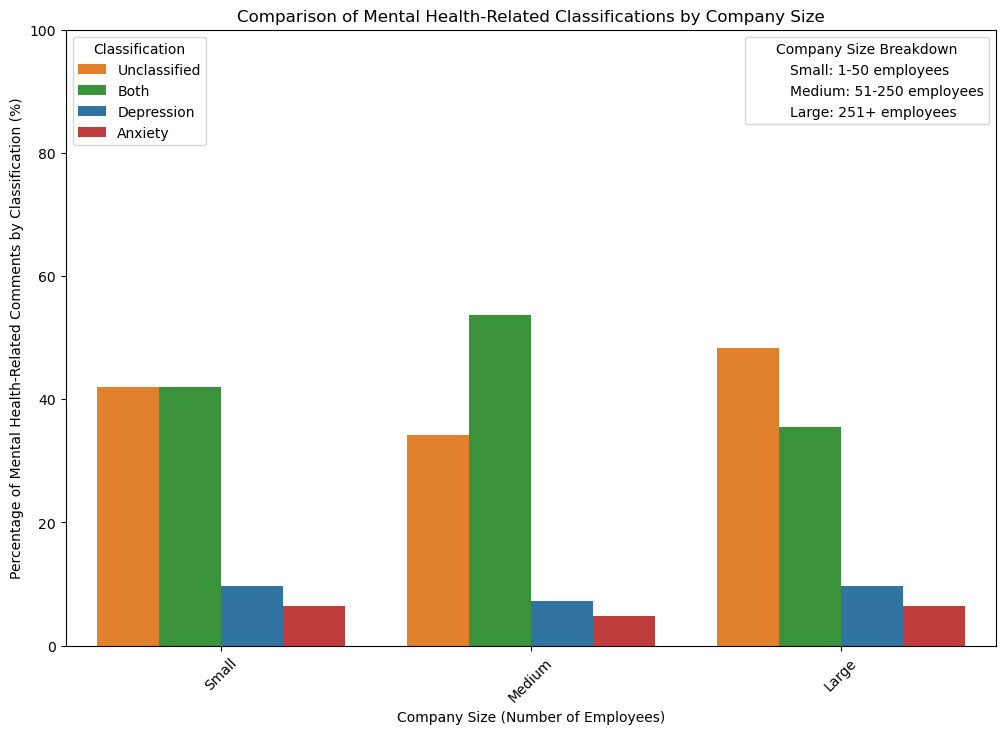

In [80]:
# Plot a bar chart for company size associated with classifications
# Ensure the company size column is treated as a categorical variable with the correct order
filtered_usa_data['company size'] = pd.Categorical(
    filtered_usa_data['company size'], 
    categories=['Small', 'Medium', 'Large'],
    ordered=True
)

# Calculate the total number of comments per company size
total_comments_per_size = filtered_usa_data.groupby('company size')['Classification'].count()

# Calculate the percentage of comments for each company size and classification combination
filtered_usa_data['Percentage'] = filtered_usa_data.groupby(['company size', 'Classification'])['Classification'].transform('count') / filtered_usa_data['company size'].map(total_comments_per_size) * 100

# Plotting the bar chart with percentage on the y-axis
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=filtered_usa_data, x='company size', y='Percentage', hue='Classification', palette=classification_colors)
plt.title('Comparison of Mental Health-Related Classifications by Company Size')
plt.xlabel('Company Size (Number of Employees)')
plt.ylabel('Percentage of Mental Health-Related Comments by Classification (%)')
plt.ylim(0, 100)  # Set the y-axis limit to 100% since it is a percentage
plt.xticks(rotation=45)

# Add the first legend (Classification)
classification_legend = ax.legend(title='Classification', loc='upper left')

# Create a custom legend for the number of employees associated with each company size
company_size_legend_labels = [
    "Small: 1-50 employees",
    "Medium: 51-250 employees",
    "Large: 251+ employees"
]

# Add the custom legend to the plot
company_size_legend = plt.legend(
    handles=[plt.Line2D([0], [0], color='w', label=label, markerfacecolor='w', markersize=0) for label in company_size_legend_labels],
    labels=company_size_legend_labels,
    loc='upper right',
    title="Company Size Breakdown"
)

# Add both legends to the plot
plt.gca().add_artist(classification_legend)

# Display the plot
plt.show()

In [81]:
# Create a df containing 'Large' Company Data
large_company_df = filtered_usa_data[filtered_usa_data['company size'] == 'Large'][['seek_help', 'leave', 'comments']].copy()
large_company_df


seek_help               leave  \
13    Don't know          Don't know   
25    Don't know           Very easy   
144   Don't know          Don't know   
231   Don't know          Don't know   
245          Yes          Don't know   
314   Don't know           Very easy   
338   Don't know          Don't know   
342   Don't know           Very easy   
372          Yes           Very easy   
378          Yes      Very difficult   
461          Yes           Very easy   
496           No  Somewhat difficult   
550           No          Don't know   
568   Don't know       Somewhat easy   
650          Yes          Don't know   
759           No          Don't know   
849          Yes          Don't know   
882   Don't know          Don't know   
889          Yes          Don't know   
894   Don't know          Don't know   
907           No          Don't know   
926   Don't know          Don't know   
934          Yes      Very difficult   
947          Yes       Somewhat easy   
973          Yes          Don't know   
1050          No          Don't know   
1077         Yes      Very difficult   
1082          No  Somewhat difficult   
1097  Don't know  Somewhat difficult   
1098  Don't know       Somewhat easy   
1219         Yes           Very easy   

                                               comments  
13    I'm not on my company's health insurance which...  
25    Sometimes I think  about using drugs for my me...  
144   I'd be more worried about coworkers and workpl...  
231   I found it difficult to answer all of the ques...  
245   I have only discussed my mental illness with c...  
314   Don't know because I haven't checked not becau...  
338   I think there might be some bugs in my thought...  
342   Regardless of a stated lack of negative conseq...  
372   My refer to the mental health issue of depress...  
378                            I work for a university.  
461   I currently have the best managers I've ever w...  
496   Stigma is the worst. People first language is ...  
550   I'm not aware of anyone with mental health iss...  
568   Mental health issue I have dealt with: acute d...  
650   I mostly suffer from social anxiety which keep...  
759   I have Narcolepsy and have been fired from a j...  
849   While not personally affected I do have immedi...  
882   (yes but the situation was unusual and involve...  
889   I would add that while there were negative con...  
894                         Bipolar spectrum is tricky.  
907   While I have not seen any direct retaliation a...  
926   My employer gives access to basic counseling a...  
934                     * Small family business - YMMV.  
947   I have an exceptional employer. I haven't run ...  
973        Thank you for shining a light on this topic.  
1050  I should note one of the places my employer fa...  
1077  I answered based on previous job at large tech...  
1082  This issue for me is very real at the moment. ...  
1097  Really manager dependent. I have had managers ...  
1098  Though it doesn't affect me (male) good job fo...  
1219  I openly discuss my mental health struggles. I...

In [82]:
# Separate the comments by classification
comments_by_classification = large_company_df.groupby('Classification')['comments'].apply(list)

# Print the comments grouped by classification
for classification, comments in comments_by_classification.items():
    print(f"\nClassification: {classification}")
    print(f"Number of Comments: {len(comments)}")
    print("Comments:")
    for comment in comments:
        print(f"- {comment}")
    print("\n" + "-"*50 + "\n")

KeyError: 'Classification'

### Gauging Employee Sentiment: The Emotional Toll of Working in Large Tech Companies 
Conducting a sentiment analysis was crucial in this context to quantify the emotional tone of the comments provided by employees at large companies. While raw data and word clouds highlighted key themes and issues, sentiment analysis adds a deeper layer by revealing how employees truly feel about these topics. By categorizing comments as either positive, negative, or neutral we gain a clearer understanding of the overall mood and satisfaction within the workforce.

The sentiment analysis was conducted using TextBlob, which calculates the polarity of each comment, giving it a score ranging from -1 (very negative) to +1 (very positive), with 0 being neutral. Additionally, TextBlob calculates the subjectivity of the text, ranging from 0 (completely objective) to 1 (completely subjective). These metrics provide valuable insights into both the emotional tone and the degree of personal bias in the comments.

The analysis results show that a significant majority of the comments are negative, indicating widespread frustration, dissatisfaction, and concern among employees. This insight is critical as it emphasizes the emotional impact of these issues and underscores the urgency of addressing mental health challenges in the workplace.

C:\Users\sunny\AppData\Local\Temp\ipykernel_4660\4008966407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_company_df['Polarity'] = large_company_df['comments'].apply(get_sentiment)
C:\Users\sunny\AppData\Local\Temp\ipykernel_4660\4008966407.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_company_df['Sentiment'] = large_company_df['Polarity'].apply(lambda p: 'positive' if p > 0 else ('negative' if p < 0 else 'neutral'))


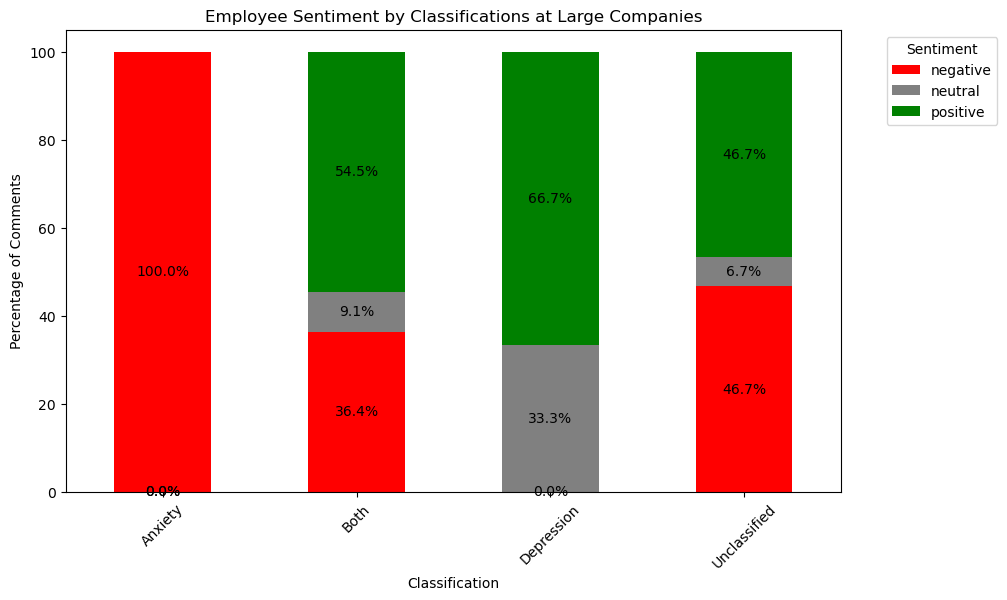

In [ ]:
# Define a function to get sentiment from TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    # Return polarity score
    return analysis.sentiment.polarity

# Apply sentiment analysis to each comment
large_company_df['Polarity'] = large_company_df['comments'].apply(get_sentiment)

# Classify sentiment based on polarity score
large_company_df['Sentiment'] = large_company_df['Polarity'].apply(lambda p: 'positive' if p > 0 else ('negative' if p < 0 else 'neutral'))

# Create a cross-tabulation of sentiment by classification
cross_tab = pd.crosstab(large_company_df['Classification'], large_company_df['Sentiment'], normalize='index') * 100

# Plotting the cross-tabulation as a stacked bar chart with custom colors
colors = ['red', 'gray', 'green']  # Red for negative, gray for neutral, green for positive
ax = cross_tab.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Add percentage labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

# Add labels and title
plt.xlabel('Classification')
plt.ylabel('Percentage of Comments')
plt.title('Employee Sentiment by Classifications at Large Companies')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Filter comments classified as 'Depression' and 'positive'
positive_depression_comments = large_company_df[(large_company_df['Classification'] == 'Depression') & (large_company_df['Sentiment'] == 'positive')]

# Display the comments
print(positive_depression_comments[['comments', 'Polarity']])

                                              comments  Polarity
372  My refer to the mental health issue of depress...  0.016667
568  Mental health issue I have dealt with: acute d...  0.250000


### Unveiling the Mental Health Crisis in Large Tech Companies

Building on the insights from the bar chart, we filtered the dataset to focus specifically on comments from employees at large companies. By generating a new word cloud, we visually compared the general concerns among employees whose comments were classified under specific mental health conditions (Depression, Anxiety, or Both), as illustrated in the first word cloud. In contrast, we created a second word cloud to highlight the emphasis within the 'unclassified' comments. Comparing and contrasting these visuals allowed us to understand the different narratives and uncover underlying patterns.

For employees like Sam, who work in large companies, these concerns aren't just fleeting worries—they often represent significant, chronic conditions that require serious attention and care. Sam’s experience reflects a broader issue: the intense pressures and demands of large organizations can exacerbate mental health challenges, turning them into ongoing struggles that impact employees' well-being and productivity. 

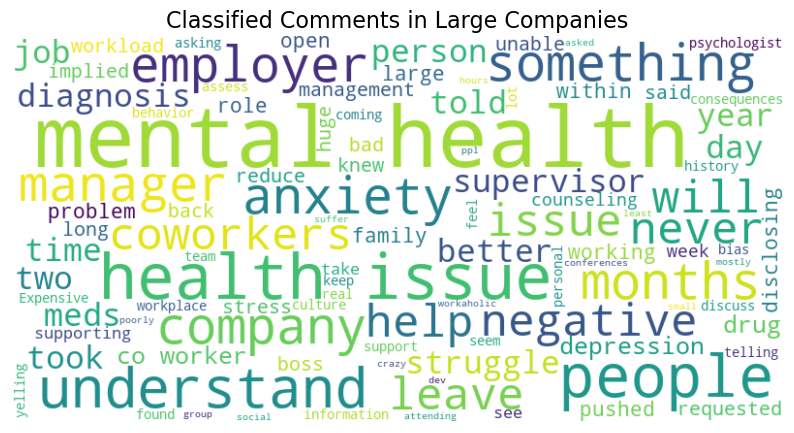

In [ ]:
# Filter comments for each classification
anxiety_comments = large_company_df[large_company_df['Classification'] == 'Anxiety']['comments']
depression_comments = large_company_df[large_company_df['Classification'] == 'Depression']['comments']
both_comments = large_company_df[large_company_df['Classification'] == 'Both']['comments']

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["could", "would", "big", "comming", "say", "answer", "us", "might", "not", "also", "I'm", "I've", "they", "one", "get", "go", "think", "really", "work", "still", "even", "much", "well", "things", "going", "make", "want", "need", "know"])

# Combine all comments from different classifications into a single string
all_comments_text = " ".join(comment for comment in pd.concat([anxiety_comments, depression_comments, both_comments]))

# Generate the word cloud with custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100, stopwords=custom_stopwords).generate(all_comments_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Classified Comments in Large Companies', fontsize=16)
plt.show()

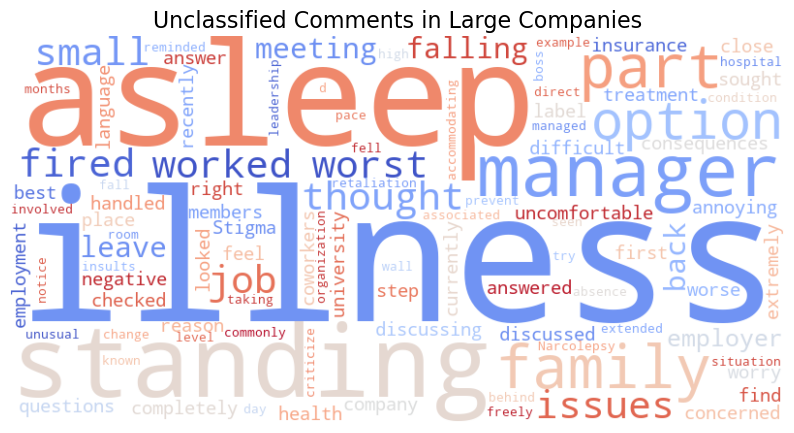

In [ ]:
# Word Cloud for only "unclassified" comments
# Filter comments for the 'Unclassified' classification
unclassified_comments = large_company_df[large_company_df['Classification'] == 'Unclassified']['comments']

# Combine all the comments into a single string
text = " ".join(comment for comment in unclassified_comments)

# Define custom stopwords to remove common but uninformative words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "could", "would", "might", "not", "also", "I'm", "I've", "they", "one", "would've", "given",
    "get", "go", "think", "really", "work", "still", "even", "much", "well", "next", "anyone",
    "things", "going", "make", "want", "need", "know", "don", "just", "didn", "bugs", "yes",
    "doesn", "said", "like", "many", "use", "lot", "time", "new", "good", "mental", "people"
])

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='coolwarm', 
    max_words=100, 
    stopwords=custom_stopwords,
    contour_color='steelblue',  
    contour_width=1
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.title('Unclassified Comments in Large Companies', fontsize=16)
plt.show()

## Do These Companies Offer Resources?
To conclude our analysis, it was essential to examine whether large companies provide adequate resources for employees struggling with their mental health. Specifically, we focused on the availability of help and the ease of taking leave.

The bar charts reveal critical gaps in the support systems, offering clear insights into the negative sentiments and challenges faced by employees across different classifications. A recurring theme in both charts is the significant percentage of responses labeled "Don't Know." This indicates a troubling lack of communication and awareness regarding available resources—a gap that may be contributing to the very issues employees are hesitant or unable to address.

#### Survey Questions: 
Leave: How easy is it for you to take medical leave for a mental health condition?

Seek Help: Does your employer provide resources to learn more about mental health issues and how to seek help? 

In [ ]:
# Create a new column to classify data into 'Classified' and 'Unclassified'
large_company_df['data_type'] = large_company_df['classification'].apply(lambda x: 'Classified' if x in ['Both', 'Depression', 'Anxiety'] else 'Unclassified')

# Calculate the value counts for 'seek_help' responses by classification
value_counts = large_company_df.groupby(['data_type', 'seek_help']).size().reset_index(name='counts')
value_counts['percentage'] = value_counts.groupby('data_type')['counts'].apply(lambda x: x / x.sum() * 100)

# Create the Altair chart with a dropdown selector
dropdown = alt.binding_select(options=['Classified', 'Unclassified'], name='Data Type ')
selection = alt.selection_single(fields=['data_type'], bind=dropdown, init={'data_type': 'Classified'})

chart = alt.Chart(value_counts).mark_bar().encode(
    x=alt.X('seek_help:N', title='Survey Categories'),
    y=alt.Y('percentage:Q', title='Percentage of Response (%)'),
    color=alt.Color('seek_help:N', title='Seek Help Response'),
    tooltip=['seek_help', 'percentage']
).add_selection(
    selection
).transform_filter(
    selection
).properties(
    width=600,
    height=400,
    title='Opportunities to Seek Help in Large Companies (Classified vs. Unclassified Data)'
)

chart.show()

KeyError: 'classification'

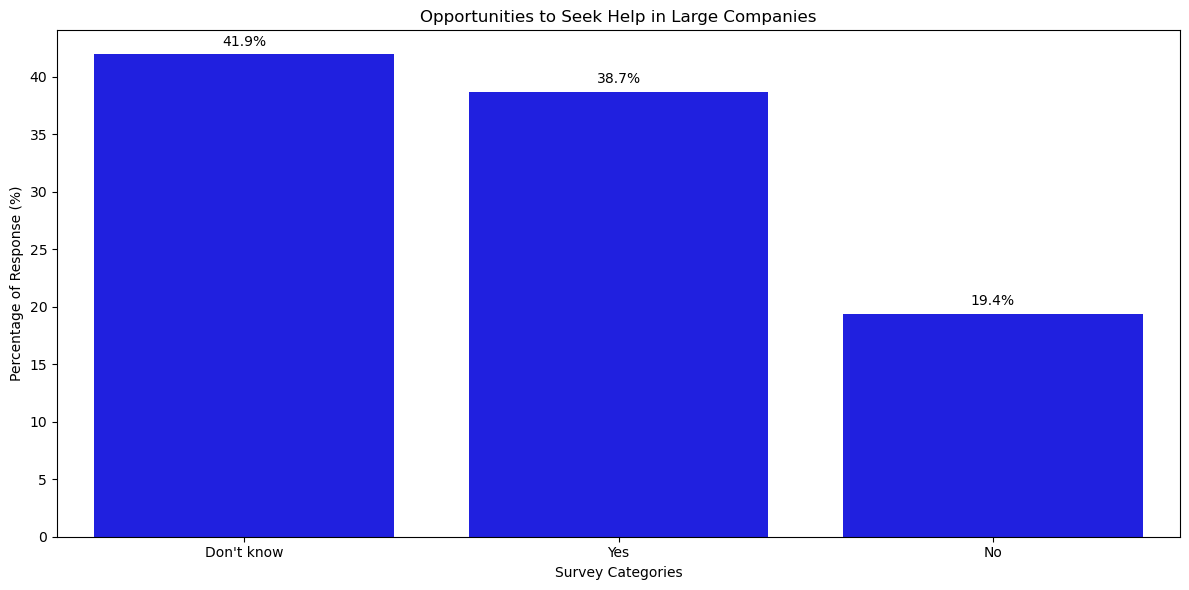

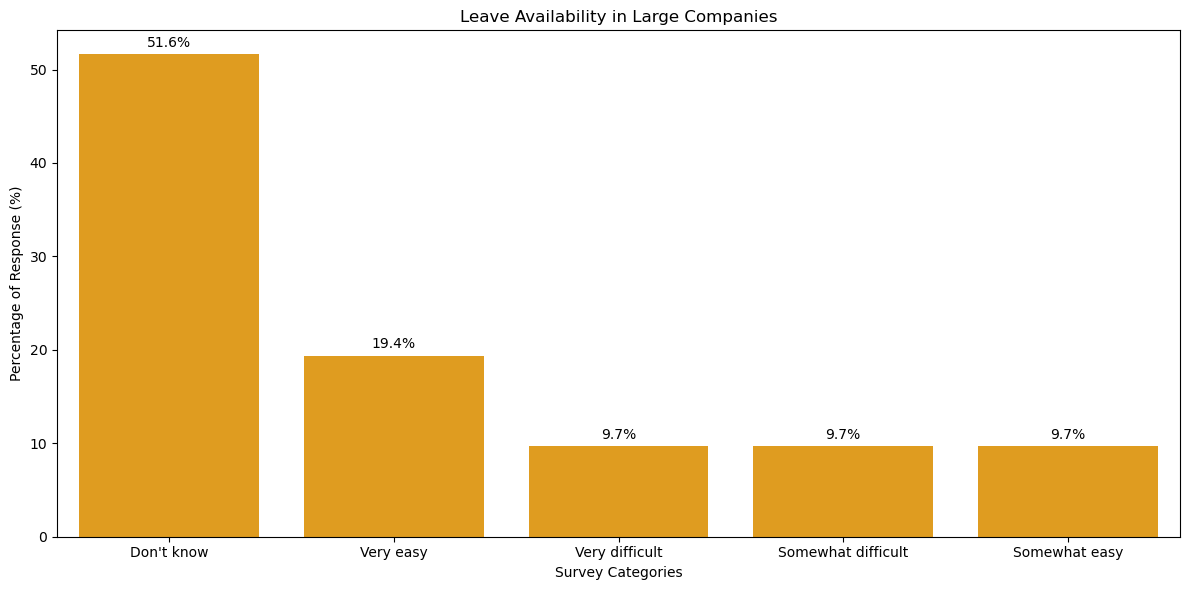

In [ ]:
# Calculate value counts and normalize for percentages for the 'Large' companies
seek_help_counts = large_company_df['seek_help'].value_counts(normalize=True) * 100
leave_counts = large_company_df['leave'].value_counts(normalize=True) * 100

# Plotting Separate Bar Chart for "Seek Help" using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=seek_help_counts.index, y=seek_help_counts.values, color="blue")
plt.title('Opportunities to Seek Help in Large Companies')
plt.xlabel('Survey Categories')
plt.ylabel('Percentage of Response (%)')

# Add percentage labels to the bars
for index, value in enumerate(seek_help_counts):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting Separate Bar Chart for "Leave Availability" using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=leave_counts.index, y=leave_counts.values, color="orange")
plt.title('Leave Availability in Large Companies')
plt.xlabel('Survey Categories')
plt.ylabel('Percentage of Response (%)')

# Add percentage labels to the bars
for index, value in enumerate(leave_counts):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### A Call to Action
Sam's story is a reflection of a broader, systemic issue in the tech industry. As we've seen through the data, mental health challenges are widespread, with many employees feeling unsupported, overworked, and overwhelmed. The imbalance between how mental health and physical health are treated is stark, and it’s contributing to a work culture that is unsustainable for many.

The data tells us that issues like anxiety, depression, and the need for therapy or support are not isolated to a few individuals; they are pervasive across the industry, affecting employees in companies of all sizes. Large companies, in particular, show a troubling trend where these issues are more frequently reported, likely due to the high-pressure environment that Sam and many others find themselves in.

#### Recommendations: Supporting Sam and Others Like Her

1. **Prioritize Mental Health Equally with Physical Health**: Employers must take active steps to ensure that mental health is given the same attention as physical health. This includes offering comprehensive mental health benefits, regular mental health check-ins, and fostering a culture where it’s safe to discuss mental health openly.

2. **Create a Supportive Environment**: Companies should implement programs that support work-life balance, stress management, and mental health awareness. Offering mental health days, promoting flexible work hours, and providing access to counseling can make a significant difference.

3. **Tailor Support to Company Size**: Recognize that the challenges faced by employees can vary depending on the size of the company. Large companies may need to focus on personalizing support and reducing the sense of isolation, while smaller companies might need to address resource limitations and ensure employees feel their voices are heard.

#### Looking Ahead: Building a Healthier Tech Industry

Sam's journey is emblematic of a much larger issue, but it’s not too late to change the narrative. By taking these recommendations to heart, the tech industry can begin to turn the tide, creating workplaces that not only foster innovation but also care for the people behind the code.

As we move forward, let’s ensure that the tech industry doesn’t just lead in technology, but also in how it treats its most valuable resource—its people. Sam’s story is one of many, but with the right changes, it could be one of hope and recovery, rather than burnout and despair.